In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input
from tensorflow.keras.optimizers import Adam 
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# If you're using TensorFlow, suppress its specific logging
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Load data
data = pd.read_csv("C:/Users/Adithya Murali/Downloads/reduced_sax_presnap.csv")
data = data.dropna(subset=['playOutcome'])


# Preprocess Time and Drop Unused Columns
data["hour"] = pd.to_datetime(data["time"]).dt.hour
data = data.drop(columns=["position", "time"])

# Encode playOutcome using LabelEncoder
label_encoder = LabelEncoder()
data['playOutcome_encoded'] = label_encoder.fit_transform(data['playOutcome'])

# Convert all boolean columns to integers
bool_cols = data.select_dtypes(include=['bool']).columns
data[bool_cols] = data[bool_cols].astype(int)

# Preprocess SAX Columns
sax_columns = ['sax_X_std', 'sax_Y_std', 'sax_a', 'sax_s', 'sax_o', 'sax_dir']
max_length = max(len(seq) for col in sax_columns for seq in data[col])

# Step 1: Preprocess SAX Columns
char_to_int = {}
for column in sax_columns:
    for char in ''.join(data[column].values):
        if char not in char_to_int:
            char_to_int[char] = len(char_to_int) + 1

def one_hot_encode_sax(data, sax_columns, max_positions, char_to_int):
    for col in sax_columns:
        for pos in range(max_positions):
            data[f"{col}_pos_{pos+1}"] = data[col].apply(
                lambda seq: char_to_int.get(seq[pos], 0)
            )

    # Create one-hot encoded columns for each position and character
    for col in sax_columns:
        for pos in range(max_positions):
            for char in char_to_int.keys():
                data[f"{col}_pos_{pos+1}_{char}"] = data[f"{col}_pos_{pos+1}"].apply(
                    lambda x: 1 if x == char_to_int[char] else 0
                )

    # Drop the original integer-encoded columns
    data.drop(columns=[f"{col}_pos_{pos+1}" for col in sax_columns for pos in range(max_positions)], inplace=True)

# Apply one-hot encoding to your DataFrame
one_hot_encode_sax(data, sax_columns, max_length, char_to_int)

data = data.drop(columns = sax_columns)
data = data.drop(columns=["playOutcome", "Unnamed: 0", "yardlineSide"]) # drop columns we don't need anymore

# Preprocess Additional Features
numeric_features = [
    "hour", "week", "quarter", "down", "yardsToGo", "yardlineNumber",
    "gameClock_min", "gameClock_sec", "preSnapHomeScore", "preSnapVisitorScore",
    "absoluteYardlineNumber", "preSnapHomeTeamWinProbability", "expectedPoints",
    "weight", "age", "time_diff", "distance", "height_inches"
]

for feature in numeric_features:
    if feature in data.columns:
        data[feature] = pd.to_numeric(data[feature], errors='coerce')
        data[feature] = (data[feature] - data[feature].mean()) / data[feature].std()
        data[feature] = data[feature].fillna(0)


categorical_features = list(set(data.columns) - set(numeric_features + ['playOutcome_encoded']))
categorical_data = pd.get_dummies(data[categorical_features]).values
numeric_data = data[numeric_features].fillna(0).values


# Prepare features and labels
X = np.hstack([numeric_data, categorical_data])
y = data['playOutcome_encoded'].values
num_classes = len(np.unique(y))

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify = y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=1
)


# Define the model
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))

# Add Dense layers with BatchNormalization and Dropout
for _ in range(5):
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

# Output layer
model.add(Dense(num_classes, activation='softmax'))

optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,         # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore the best weights after stopping
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]  # Add early stopping callback
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Epoch 1/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.0951 - loss: 3.4870 - val_accuracy: 0.1576 - val_loss: 2.5508
Epoch 2/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1037 - loss: 3.2707 - val_accuracy: 0.1576 - val_loss: 2.5271
Epoch 3/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1096 - loss: 3.1191 - val_accuracy: 0.1576 - val_loss: 2.5007
Epoch 4/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1157 - loss: 3.0053 - val_accuracy: 0.1576 - val_loss: 2.4641
Epoch 5/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1336 - loss: 2.8554 - val_accuracy: 0.1576 - val_loss: 2.4371
Epoch 6/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1334 - loss: 2.8409 - val_accuracy: 0.1576 - val_loss: 2.4310
Epoch 7/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1410 - loss: 2.7471 - val_accuracy: 0.1576 - val_loss: 2.4068
Epoch 8/500
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1951 - loss: 2.5769 - val_accuracy: 0.

Class Distribution Before SMOTE: Counter({9: 327, 4: 187, 5: 117, 3: 102, 8: 61, 11: 50, 2: 49, 10: 46, 7: 46, 6: 45, 0: 35, 1: 27, 12: 5})
Class Distribution After Partial SMOTE: Counter({9: 327, 4: 187, 5: 117, 3: 102, 2: 98, 10: 98, 0: 98, 11: 98, 7: 98, 8: 98, 6: 98, 1: 98, 12: 98})
Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.1000 - loss: 3.2296 - val_accuracy: 0.1777 - val_loss: 4.2348 - learning_rate: 0.0010
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.1732 - loss: 2.7961 - val_accuracy: 0.1901 - val_loss: 2.8431 - learning_rate: 0.0010
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.2533 - loss: 2.4414 - val_accuracy: 0.2521 - val_loss: 2.9544 - learning_rate: 0.0010
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step - accuracy: 0.4145 - loss: 1.9049 - val_accuracy: 0.2107 - val_loss: 2.8460 - learning_rate: 0.0010
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.5273 - loss: 1.5362 - val_accuracy: 0

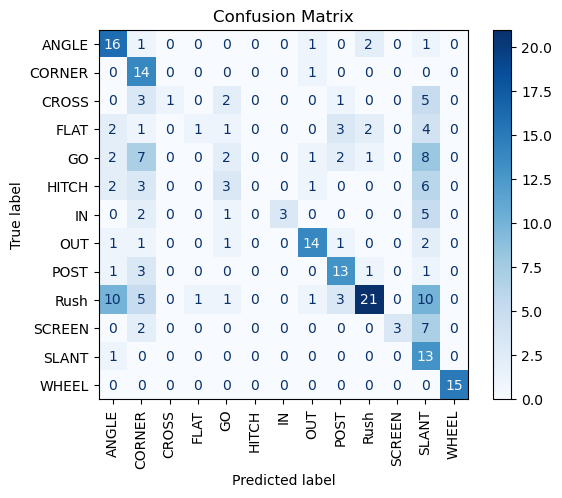

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import matplotlib.pyplot as plt

from sklearn.metrics import (
    classification_report, accuracy_score, precision_score,
    recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
)

# Load data
data = pd.read_csv("C:/Users/Adithya Murali/Downloads/reduced_sax_presnap.csv")
data = data.dropna(subset=['playOutcome'])  
# Preprocess Time and Drop Unused Columns
data["hour"] = pd.to_datetime(data["time"]).dt.hour
data = data.drop(columns=["position", "time"])

# Encode playOutcome using LabelEncoder
label_encoder = LabelEncoder()
data['playOutcome_encoded'] = label_encoder.fit_transform(data['playOutcome'])

# Convert all boolean columns to integers
bool_cols = data.select_dtypes(include=['bool']).columns
data[bool_cols] = data[bool_cols].astype(int)

# Preprocess SAX Columns
sax_columns = ['sax_X_std', 'sax_Y_std', 'sax_a', 'sax_s', 'sax_o', 'sax_dir']

max_length = max(len(seq) for col in sax_columns for seq in data[col])

# Step 1: Preprocess SAX Columns
char_to_int = {}
for column in sax_columns:
    for char in ''.join(data[column].values):
        if char not in char_to_int:
            char_to_int[char] = len(char_to_int) + 1

def one_hot_encode_sax(data, sax_columns, max_positions, char_to_int):
    for col in sax_columns:
        for pos in range(max_positions):
            data[f"{col}_pos_{pos+1}"] = data[col].apply(
                lambda seq: char_to_int.get(seq[pos], 0)
            )

    # Create one-hot encoded columns for each position and character
    for col in sax_columns:
        for pos in range(max_positions):
            for char in char_to_int.keys():
                data[f"{col}_pos_{pos+1}_{char}"] = data[f"{col}_pos_{pos+1}"].apply(
                    lambda x: 1 if x == char_to_int[char] else 0
                )

    # Drop the original integer-encoded columns
    data.drop(columns=[f"{col}_pos_{pos+1}" for col in sax_columns for pos in range(max_positions)], inplace=True)

# Apply one-hot encoding to your DataFrame
one_hot_encode_sax(data, sax_columns, max_length, char_to_int)

# Drop unused columns
data = data.drop(columns=sax_columns)
data = data.drop(columns=["playOutcome", "Unnamed: 0", "yardlineSide"])

# Preprocess Additional Features
numeric_features = [
    "hour", "week", "quarter", "down", "yardsToGo", "yardlineNumber",
    "gameClock_min", "gameClock_sec", "preSnapHomeScore", "preSnapVisitorScore",
    "absoluteYardlineNumber", "preSnapHomeTeamWinProbability", "expectedPoints",
    "weight", "age", "time_diff", "distance", "height_inches"
]

# Handle Missing Values in Numeric Columns
numeric_imputer = SimpleImputer(strategy='mean')
data[numeric_features] = numeric_imputer.fit_transform(data[numeric_features])

# Handle Missing Values in Categorical Columns
categorical_features = list(set(data.columns) - set(numeric_features + ['playOutcome_encoded']))
categorical_imputer = SimpleImputer(strategy='most_frequent')  # Replace NaNs with the most frequent value
data[categorical_features] = categorical_imputer.fit_transform(data[categorical_features])

# Normalize features using MinMaxScaler
scaler = MinMaxScaler()
data[numeric_features] = scaler.fit_transform(data[numeric_features])

# Convert categorical features to one-hot encoding
categorical_data = pd.get_dummies(data[categorical_features]).values
numeric_data = data[numeric_features].values

# Prepare features and labels
X = np.hstack([numeric_data, categorical_data])
y = data['playOutcome_encoded'].values
num_classes = len(np.unique(y))

# Ensure no NaNs in the data
assert not np.isnan(X).any(), "Features contain NaN values!"
assert not np.isnan(y).any(), "Labels contain NaN values!"


print("Class Distribution Before SMOTE:", Counter(y))

# Define your target class sizes
majority_class_size = max(Counter(y).values())
scaling_factor = 0.3  # percentage of majority class
sampling_strategy = {
    cls: max(count, int(majority_class_size * scaling_factor))  # Ensure no class is reduced
    for cls, count in Counter(y).items()
}

# Ensure k_neighbors is valid
smallest_class_size = min(Counter(y).values())
k_neighbors = max(1, min(5, smallest_class_size - 1))

# Apply SMOTE with corrected strategy
smote = SMOTE(random_state=42, k_neighbors=k_neighbors, sampling_strategy=sampling_strategy)
X, y = smote.fit_resample(X, y)

# New class distribution
print("Class Distribution After Partial SMOTE:", Counter(y))


# Reshape X for CNN compatibility
X = np.expand_dims(X, axis=2)  # Add a channel dimension for Conv1D

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=1
)

# Define the Optimized CNN Model
model = Sequential()

# Input Layer
model.add(Input(shape=(X_train.shape[1], 1)))

# CNN Layers
model.add(Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())

# Fully Connected Layers
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Output Layer
model.add(Dense(num_classes, activation='softmax'))

# Compile the Model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1
)

# Train the Model
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the Model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_labels)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=label_encoder.classes_
)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xticks(rotation = 90)
plt.show()

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import matplotlib.pyplot as plt

from sklearn.metrics import (
    classification_report, accuracy_score, precision_score,
    recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
)

# Load data
data = pd.read_csv("C:/Users/Adithya Murali/Downloads/reduced_sax_presnap.csv")
data = data.dropna(subset=['playOutcome'])  
# Preprocess Time and Drop Unused Columns
data["hour"] = pd.to_datetime(data["time"]).dt.hour
data = data.drop(columns=["position", "time"])

# Encode playOutcome using LabelEncoder
label_encoder = LabelEncoder()
data['playOutcome_encoded'] = label_encoder.fit_transform(data['playOutcome'])

# Convert all boolean columns to integers
bool_cols = data.select_dtypes(include=['bool']).columns
data[bool_cols] = data[bool_cols].astype(int)

# Preprocess SAX Columns
sax_columns = ['sax_X_std', 'sax_Y_std', 'sax_a', 'sax_s', 'sax_o', 'sax_dir']

max_length = max(len(seq) for col in sax_columns for seq in data[col])

# Step 1: Preprocess SAX Columns
char_to_int = {}
for column in sax_columns:
    for char in ''.join(data[column].values):
        if char not in char_to_int:
            char_to_int[char] = len(char_to_int) + 1

def one_hot_encode_sax(data, sax_columns, max_positions, char_to_int):
    for col in sax_columns:
        for pos in range(max_positions):
            data[f"{col}_pos_{pos+1}"] = data[col].apply(
                lambda seq: char_to_int.get(seq[pos], 0)
            )

    # Create one-hot encoded columns for each position and character
    for col in sax_columns:
        for pos in range(max_positions):
            for char in char_to_int.keys():
                data[f"{col}_pos_{pos+1}_{char}"] = data[f"{col}_pos_{pos+1}"].apply(
                    lambda x: 1 if x == char_to_int[char] else 0
                )

    # Drop the original integer-encoded columns
    data.drop(columns=[f"{col}_pos_{pos+1}" for col in sax_columns for pos in range(max_positions)], inplace=True)

# Apply one-hot encoding to your DataFrame
one_hot_encode_sax(data, sax_columns, max_length, char_to_int)

# Drop unused columns
data = data.drop(columns=sax_columns)
data = data.drop(columns=["playOutcome", "Unnamed: 0", "yardlineSide"])

# Preprocess Additional Features
numeric_features = [
    "hour", "week", "quarter", "down", "yardsToGo", "yardlineNumber",
    "gameClock_min", "gameClock_sec", "preSnapHomeScore", "preSnapVisitorScore",
    "absoluteYardlineNumber", "preSnapHomeTeamWinProbability", "expectedPoints",
    "weight", "age", "time_diff", "distance", "height_inches"
]

# Handle Missing Values in Numeric Columns
numeric_imputer = SimpleImputer(strategy='mean')
data[numeric_features] = numeric_imputer.fit_transform(data[numeric_features])

# Handle Missing Values in Categorical Columns
categorical_features = list(set(data.columns) - set(numeric_features + ['playOutcome_encoded']))
categorical_imputer = SimpleImputer(strategy='most_frequent')  # Replace NaNs with the most frequent value
data[categorical_features] = categorical_imputer.fit_transform(data[categorical_features])

# Normalize features using MinMaxScaler
scaler = MinMaxScaler()
data[numeric_features] = scaler.fit_transform(data[numeric_features])

# Convert categorical features to one-hot encoding
categorical_data = pd.get_dummies(data[categorical_features]).values
numeric_data = data[numeric_features].values

# Prepare features and labels
X = np.hstack([numeric_data, categorical_data])
y = data['playOutcome_encoded'].values
num_classes = len(np.unique(y))

# Ensure no NaNs in the data
assert not np.isnan(X).any(), "Features contain NaN values!"
assert not np.isnan(y).any(), "Labels contain NaN values!"


print("Class Distribution Before SMOTE:", Counter(y))

# Define your target class sizes
majority_class_size = max(Counter(y).values())
scaling_factor = 0.3  # percentage of majority class
sampling_strategy = {
    cls: max(count, int(majority_class_size * scaling_factor))  # Ensure no class is reduced
    for cls, count in Counter(y).items()
}

# Ensure k_neighbors is valid
smallest_class_size = min(Counter(y).values())
k_neighbors = max(1, min(5, smallest_class_size - 1))

# Apply SMOTE with corrected strategy
smote = SMOTE(random_state=42, k_neighbors=k_neighbors, sampling_strategy=sampling_strategy)
X, y = smote.fit_resample(X, y)

# New class distribution
print("Class Distribution After Partial SMOTE:", Counter(y))


# Reshape X for CNN compatibility
X = np.expand_dims(X, axis=2)  # Add a channel dimension for Conv1D

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=1
)

# Define the Optimized CNN Model
model = Sequential()

# Input Layer
model.add(Input(shape=(X_train.shape[1], 1)))

# CNN Layers
model.add(Conv1D(filters=64, kernel_size=5, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())

# Fully Connected Layers
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Output Layer
model.add(Dense(num_classes, activation='softmax'))

# Compile the Model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1
)

test_error = []

for iteration in range(10):
    # Train the Model
    history = model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, reduce_lr]
    )

    # Evaluate the Model
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    test_error.append(test_accuracy)


Class Distribution Before SMOTE: Counter({9: 327, 4: 187, 5: 117, 3: 102, 8: 61, 11: 50, 2: 49, 10: 46, 7: 46, 6: 45, 0: 35, 1: 27, 12: 5})
Class Distribution After Partial SMOTE: Counter({9: 327, 4: 187, 5: 117, 3: 102, 2: 98, 10: 98, 0: 98, 11: 98, 7: 98, 8: 98, 6: 98, 1: 98, 12: 98})
Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 0.0917 - loss: 3.3733 - val_accuracy: 0.1736 - val_loss: 4.5935 - learning_rate: 0.0010
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.1983 - loss: 2.6728 - val_accuracy: 0.1942 - val_loss: 3.1047 - learning_rate: 0.0010
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.2326 - loss: 2.5099 - val_accuracy: 0.2066 - val_loss: 2.8075 - learning_rate: 0.0010
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.3548 - loss: 2.1643 - val_accuracy: 0.2603 - val_loss: 2.7434 - learning_rate: 0.0010
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.5223 - loss: 1.5544 - val_accuracy: 0.

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


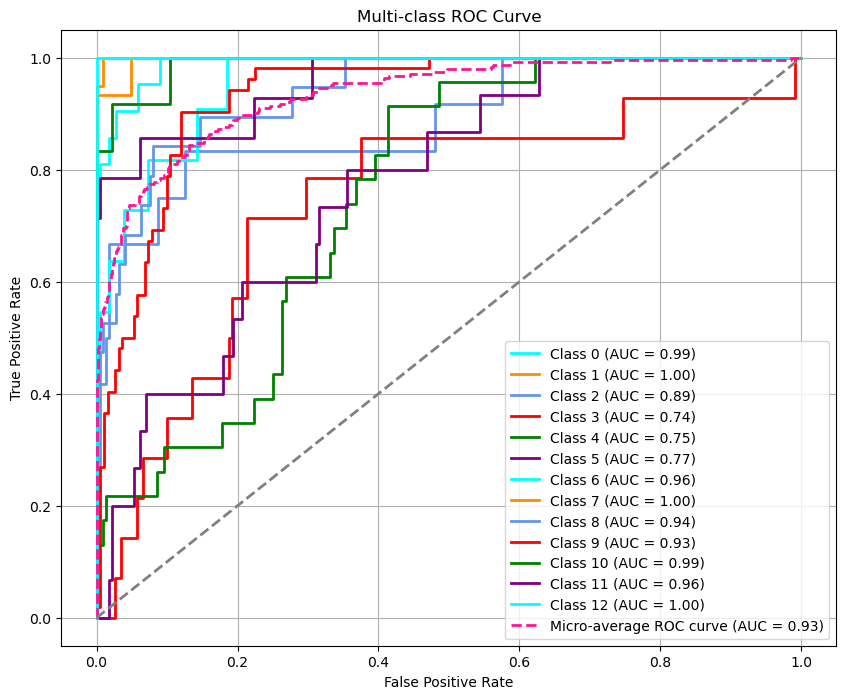

In [8]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

# Binarize the labels for multi-class AUC calculation
y_test_binarized = label_binarize(y_test, classes=np.unique(y))
n_classes = y_test_binarized.shape[1]

# Get model probabilities
y_score = model.predict(X_test)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot the ROC curve for each class
plt.figure(figsize=(10, 8))
colors = cycle(["aqua", "darkorange", "cornflowerblue", "red", "green", "purple"])

for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=2,
        label=f"Class {i} (AUC = {roc_auc[i]:.2f})"
    )

# Plot the micro-average ROC curve
plt.plot(
    fpr["micro"],
    tpr["micro"],
    color="deeppink",
    linestyle="--",
    linewidth=2,
    label=f"Micro-average ROC curve (AUC = {roc_auc['micro']:.2f})"
)

# Plot the diagonal
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", lw=2)

plt.title("Multi-class ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()
